In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
import pandas as pd
import os
from tqdm import tqdm
from utils import collect_acts
from generate_acts import load_llama
from probes import LRProbe, MMProbe, CCSProbe
import plotly.express as px
import json

In [3]:
model_size = '13B-2'
device = 'cuda:0'

tokenizer, model = load_llama(model_size, device)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/storage/models/llama-2-13B-GPTQ-4bit


In [4]:
prompt = """\
The Spanish word 'jirafa' means 'giraffe'. This statement is: TRUE
The Spanish word 'escribir' means 'to write'. This statement is: TRUE
The Spanish word 'diccionario' means 'dictionary'. This statement is: TRUE
The Spanish word 'gato' means 'cat'. This statement is: TRUE
The Spanish word 'aire' means 'silver'. This statement is: FALSE"""

statement="The Spanish word 'hola' means 'goodbye'."
input_ids = tokenizer(prompt + '\n' +  statement + ' This statement is:', return_tensors='pt').input_ids.to(device)
probs = model(input_ids).logits[0,-1,:].softmax(-1)

In [5]:
t_tok = tokenizer.encode('TRUE')[-1]
f_tok = tokenizer.encode('FALSE')[-1]

probs[t_tok], probs[f_tok]

(tensor(0.0190, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(0.9768, device='cuda:0', grad_fn=<SelectBackward0>))

# Experiment

## False -> true

354it [00:18, 18.67it/s]


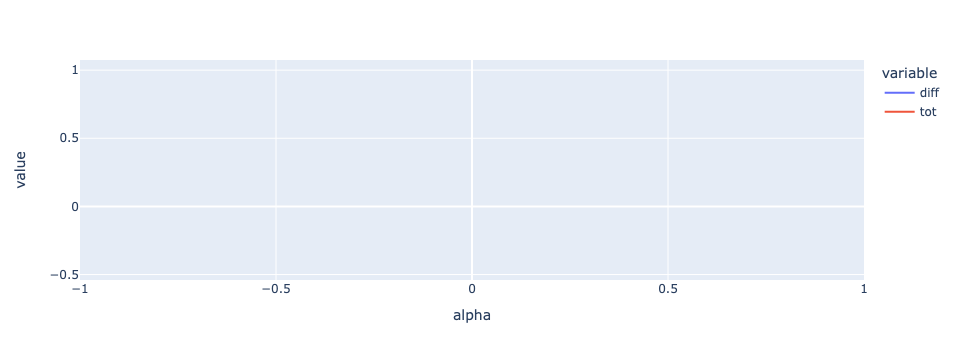

In [17]:
layer = 13

train_datasets = ['cities']
val_dataset = 'sp_en_trans'

ProbeClass = MMProbe

# label tokens
t_tok = tokenizer.encode('TRUE')[-1]
f_tok = tokenizer.encode('FALSE')[-1]

# get probe
if ProbeClass == LRProbe or ProbeClass == MMProbe:
    acts, labels = [], []
    for dataset in train_datasets:
        acts.append(collect_acts(dataset, model_size, layer).to(device))
        labels.append(t.Tensor(pd.read_csv(f'datasets/{dataset}.csv')['label'].tolist()).to(device))
    acts, labels = t.cat(acts), t.cat(labels)
    probe = ProbeClass.from_data(acts, labels, device=device)
elif ProbeClass == CCSProbe:
    acts = collect_acts(train_datasets[0], model_size, layer, device=device)
    neg_acts = collect_acts(train_datasets[1], model_size, layer, device=device)
    labels = t.Tensor(pd.read_csv(f'datasets/{train_datasets[0]}.csv')['label'].tolist()).to(device)
    probe = ProbeClass.from_data(acts, neg_acts, labels=labels, device=device)

# get direction
direction = probe.direction
true_acts, false_acts = acts[labels==1], acts[labels==0]
true_mean, false_mean = true_acts.mean(0), false_acts.mean(0)
direction = direction / direction.norm()
diff = (true_mean - false_mean) @ direction
direction = diff * direction

prompt = """\
The Spanish word 'jirafa' means 'giraffe'. This statement is: TRUE
The Spanish word 'escribir' means 'to write'. This statement is: TRUE
The Spanish word 'diccionario' means 'dictionary'. This statement is: TRUE
The Spanish word 'gato' means 'cat'. This statement is: TRUE
The Spanish word 'aire' means 'silver'. This statement is: FALSE"""

# make sure everything is clean going in
for module in model.model.layers:
    module._forward_hooks.clear()

df_out = {'alpha' : [], 'diff' : [], 'tot' : []}

# keep increasing alpha until things get worse
# last_diff = -2
# diff = -1
# tot = 1
# alpha = -1
# while diff > last_diff and tot > .95:
# last_diff = diff
# alpha += 1
alpha = 0
# get probs
df = pd.read_csv(f'datasets/{val_dataset}.csv')
diffs, tots = [], []
for _, row in tqdm(df.iterrows()):
    if row['label'] == 0 and row['statement'] not in prompt:
        input_ids = tokenizer(prompt + '\n' +  row['statement'] + ' This statement is:', return_tensors='pt').input_ids.to(device)
        period_tok = tokenizer.encode("'test'.")[-1]
        period_idxs = (input_ids == period_tok).nonzero(as_tuple=True)[1]
        intervention_idx = period_idxs[5]

        # intervened prob
        def hook(module, input, output):
            output[0][:,intervention_idx - 1, :] += direction * alpha
            output[0][:, intervention_idx, :] += direction * alpha
            return output
        handle = model.model.layers[layer-1].register_forward_hook(hook)
        probs = model(input_ids).logits[0,-1,:].softmax(-1)
        handle.remove()

        diffs.append(probs[t_tok].item() - probs[f_tok].item())
        tots.append(probs[t_tok].item() + probs[f_tok].item())
diff = sum(diffs) / len(diffs)
tot = sum(tots) / len(tots)
df_out['alpha'].append(alpha)
df_out['diff'].append(diff)
df_out['tot'].append(tot)

# save results
log = {
    'train_datasets' : train_datasets,
    'val_dataset' : val_dataset,
    'layer' : layer,
    'probe class' : ProbeClass.__name__,
    'prompt' : prompt,
    'results' : df_out,
    'experiment' : 'false to true'
}

with open('experimental_outputs/label_change_intervention_results.json', 'r') as f:
    data = json.load(f)
data.append(log)
with open('experimental_outputs/label_change_intervention_results.json', 'w') as f:
    json.dump(data, f, indent=4)

px.line(pd.DataFrame(df_out), x='alpha', y=['diff', 'tot'])

## True -> false

In [19]:
layer = 10

train_datasets = ['cities']
val_dataset = 'sp_en_trans'

ProbeClass = MMProbe

# label tokens
t_tok = tokenizer.encode('TRUE')[-1]
f_tok = tokenizer.encode('FALSE')[-1]

# get probe
if ProbeClass == LRProbe or ProbeClass == MMProbe:
    acts, labels = [], []
    for dataset in train_datasets:
        acts.append(collect_acts(dataset, model_size, layer).to(device))
        labels.append(t.Tensor(pd.read_csv(f'datasets/{dataset}.csv')['label'].tolist()).to(device))
    acts, labels = t.cat(acts), t.cat(labels)
    probe = ProbeClass.from_data(acts, labels, device=device)
elif ProbeClass == CCSProbe:
    acts = collect_acts(train_datasets[0], model_size, layer, device=device)
    neg_acts = collect_acts(train_datasets[1], model_size, layer, device=device)
    labels = t.Tensor(pd.read_csv(f'datasets/{train_datasets[0]}.csv')['label'].tolist()).to(device)
    probe = ProbeClass.from_data(acts, neg_acts, labels=labels, device=device)

# get direction
direction = probe.direction
true_acts, false_acts = acts[labels==1], acts[labels==0]
true_mean, false_mean = true_acts.mean(0), false_acts.mean(0)
direction = direction / direction.norm()
diff = (true_mean - false_mean) @ direction
direction = diff * direction

prompt = """\
The Spanish word 'jirafa' means 'giraffe'. This statement is: TRUE
The Spanish word 'escribir' means 'to write'. This statement is: TRUE
The Spanish word 'diccionario' means 'dictionary'. This statement is: TRUE
The Spanish word 'gato' means 'cat'. This statement is: TRUE
The Spanish word 'aire' means 'silver'. This statement is: FALSE"""

# make sure everything is clean going in
for module in model.model.layers:
    module._forward_hooks.clear()

df_out = {'alpha' : [], 'diff' : [], 'tot' : []}

# keep decreasing alpha until things get worse
# last_diff = 2
# diff = 1
# tot = 1
# alpha = -1
# while diff < last_diff and tot > .95:
    # last_diff = diff
    # alpha += 1
    # get probs
alpha = 6
df = pd.read_csv(f'datasets/{val_dataset}.csv')
diffs, tots = [], []
for _, row in tqdm(df.iterrows()):
    if row['label'] == 1 and row['statement'] not in prompt:
        input_ids = tokenizer(prompt + '\n' +  row['statement'] + ' This statement is:', return_tensors='pt').input_ids.to(device)
        period_tok = tokenizer.encode("'test'.")[-1]
        period_idxs = (input_ids == period_tok).nonzero(as_tuple=True)[1]
        intervention_idx = period_idxs[5]

        # intervened prob
        def hook(module, input, output):
            output[0][:,intervention_idx - 1, :] -= direction * alpha
            output[0][:, intervention_idx, :] -= direction * alpha
            return output
        handle = model.model.layers[layer-1].register_forward_hook(hook)
        probs = model(input_ids).logits[0,-1,:].softmax(-1)
        handle.remove()

        diffs.append(probs[t_tok].item() - probs[f_tok].item())
        tots.append(probs[t_tok].item() + probs[f_tok].item())
diff = sum(diffs) / len(diffs)
tot = sum(tots) / len(tots)
df_out['alpha'].append(alpha)
df_out['diff'].append(diff)
df_out['tot'].append(tot)

# save results
log = {
    'train_datasets' : train_datasets,
    'val_dataset' : val_dataset,
    'layer' : layer,
    'probe class' : ProbeClass.__name__,
    'prompt' : prompt,
    'results' : df_out,
    'experiment' : 'true to false'
}

with open('experimental_outputs/label_change_intervention_results.json', 'r') as f:
    data = json.load(f)
data.append(log)
with open('experimental_outputs/label_change_intervention_results.json', 'w') as f:
    json.dump(data, f, indent=4)

px.line(pd.DataFrame(df_out), x='alpha', y=['diff', 'tot'])

41it [00:01, 21.73it/s]


KeyboardInterrupt: 

## intervene all layers

In [18]:
layer = 14
intervene_layers = range(8,15)
alpha = 1 # zero for no intervention, 1 for intervention
label_value = 1 # 1 if using true statements (true->false), 0 if false staetment (false->true)

train_datasets = ['cities']
val_dataset = 'sp_en_trans'

ProbeClass = MMProbe

# label tokens
t_tok = tokenizer.encode('TRUE')[-1]
f_tok = tokenizer.encode('FALSE')[-1]

# get probe
if ProbeClass == LRProbe or ProbeClass == MMProbe:
    acts, labels = [], []
    for dataset in train_datasets:
        acts.append(collect_acts(dataset, model_size, layer).to(device))
        labels.append(t.Tensor(pd.read_csv(f'datasets/{dataset}.csv')['label'].tolist()).to(device))
    acts, labels = t.cat(acts), t.cat(labels)
    probe = ProbeClass.from_data(acts, labels, device=device)
elif ProbeClass == CCSProbe:
    acts = collect_acts(train_datasets[0], model_size, layer, device=device)
    neg_acts = collect_acts(train_datasets[1], model_size, layer, device=device)
    labels = t.Tensor(pd.read_csv(f'datasets/{train_datasets[0]}.csv')['label'].tolist()).to(device)
    probe = ProbeClass.from_data(acts, neg_acts, labels=labels, device=device)

# get direction
direction = probe.direction
true_acts, false_acts = acts[labels==1], acts[labels==0]
true_mean, false_mean = true_acts.mean(0), false_acts.mean(0)
direction = direction / direction.norm()
diff = (true_mean - false_mean) @ direction
direction = diff * direction

prompt = """\
The Spanish word 'jirafa' means 'giraffe'. This statement is: TRUE
The Spanish word 'escribir' means 'to write'. This statement is: TRUE
The Spanish word 'diccionario' means 'dictionary'. This statement is: TRUE
The Spanish word 'gato' means 'cat'. This statement is: TRUE
The Spanish word 'aire' means 'silver'. This statement is: FALSE"""

# make sure everything is clean going in
for module in model.model.layers:
    module._forward_hooks.clear()

# get probs
df = pd.read_csv(f'datasets/{val_dataset}.csv')
diffs, tots = [], []
for _, row in tqdm(df.iterrows()):
    if row['label'] == label_value and row['statement'] not in prompt:
        input_ids = tokenizer(prompt + '\n' +  row['statement'] + ' This statement is:', return_tensors='pt').input_ids.to(device)
        period_tok = tokenizer.encode("'test'.")[-1]
        period_idxs = (input_ids == period_tok).nonzero(as_tuple=True)[1]
        intervention_idx = period_idxs[5]

        # intervened prob
        def hook(module, input, output):
            if label_value == 1:
                output[0][:,intervention_idx - 1, :] -= direction * alpha
                output[0][:, intervention_idx, :] -= direction * alpha
            else:
                output[0][:,intervention_idx - 1, :] += direction * alpha
                output[0][:, intervention_idx, :] += direction * alpha
            return output
        
        handles = []
        for layer in intervene_layers:
            handle = model.model.layers[layer].register_forward_hook(hook)
            handles.append(handle)
        probs = model(input_ids).logits[0,-1,:].softmax(-1)
        for handle in handles:
            handle.remove()

        diffs.append(probs[t_tok].item() - probs[f_tok].item())
        tots.append(probs[t_tok].item() + probs[f_tok].item())
diff = sum(diffs) / len(diffs)
tot = sum(tots) / len(tots)
print(diff, tot)

354it [00:18, 18.64it/s]

-0.6217546254568707 0.9912983856104702


## True -> False (intervene all layers)